In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [59]:
BATCH_SIZE = 2
input_size = (540, 960)
target_size = (input_size[0]*4, input_size[1]*4)

In [70]:
train_img_list_label = r"F:\dataset\UHDSR4K\4K\train\HR"
train_img_list_data = r"F:\dataset\UHDSR4K\4K\train\LR_X4"

test_img_list_label = r"F:\dataset\UHDSR4K\4K\test\HR"
test_img_list_data = r"F:\dataset\UHDSR4K\4K\test\LR_X4"


img_list_label = tf.io.matching_files(f'{train_img_list_label}\*.*')
img_list_data = tf.io.matching_files(f'{train_img_list_data}\*.*')
train_ds = tf.data.Dataset.from_tensor_slices((img_list_data, img_list_label))

img_list_label = tf.io.matching_files(f'{test_img_list_label}\*.*')
img_list_data = tf.io.matching_files(f'{test_img_list_data}\*.*')
test_ds = tf.data.Dataset.from_tensor_slices((img_list_data, img_list_label))

def read_image(img,label):
    img = tf.io.read_file(img)
    img = tf.io.decode_image(img)
    img.set_shape((*input_size,3))
    label = tf.io.read_file(label)
    label = tf.io.decode_image(label)
    label.set_shape((*target_size,3))
    img = img / 255
    label = label / 255
    return img, label

train_ds_size = train_ds.cardinality()
test_ds_size = test_ds.cardinality()
valid_ds_size = train_ds_size // 5

valid_ds = train_ds.take(valid_ds_size)
train_ds = train_ds.skip(valid_ds_size)

train_ds_size = train_ds.cardinality()
test_ds_size = test_ds.cardinality()
valid_ds_size = train_ds_size // 5

sample = next(iter(train_ds))

train_ds = train_ds.map(read_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.map(read_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(read_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_ds)
print(train_ds_size)
print(test_ds_size)
print(valid_ds_size)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 540, 960, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2160, 3840, 3), dtype=tf.float32, name=None))>
tf.Tensor(4800, shape=(), dtype=int64)
tf.Tensor(2100, shape=(), dtype=int64)
tf.Tensor(960, shape=(), dtype=int64)


(2, 540, 960, 3)
(2, 2160, 3840, 3)


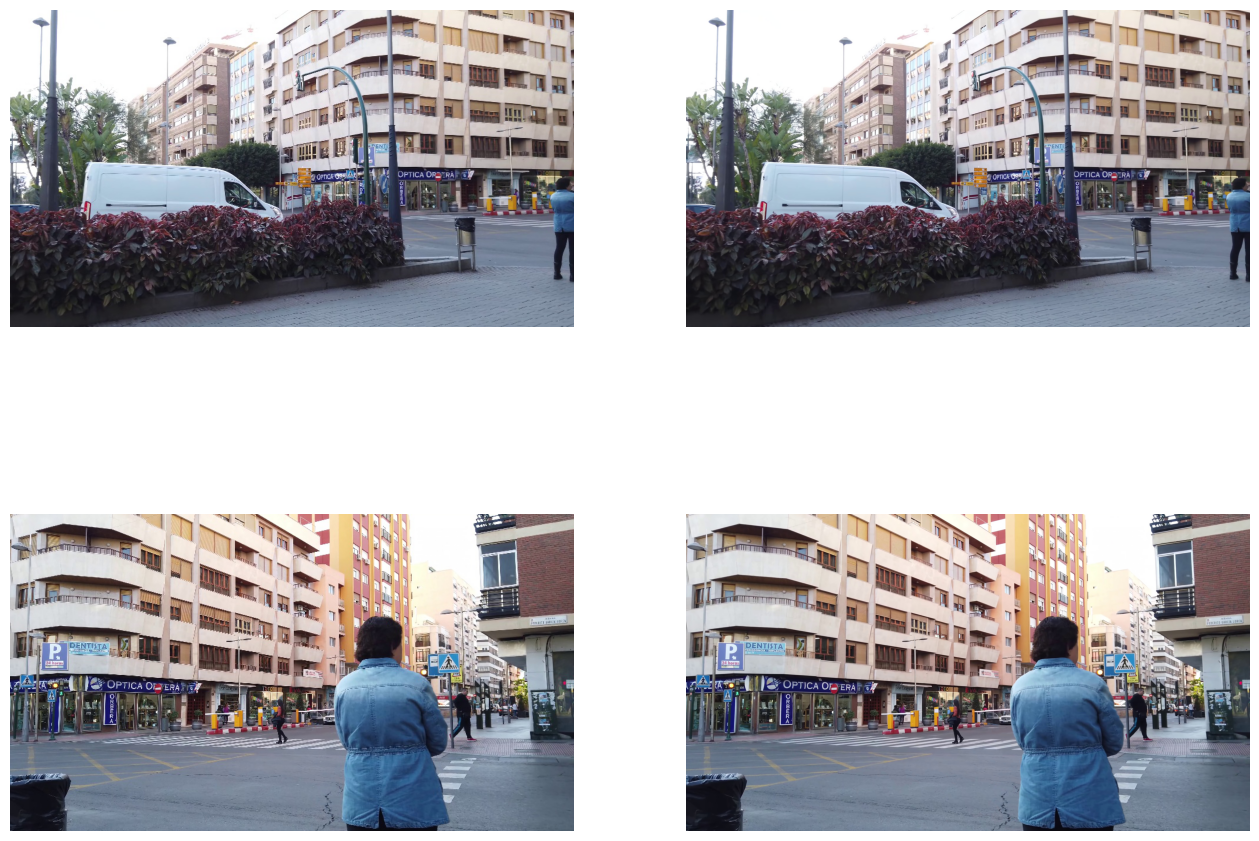

In [71]:
# visualize data
sample = next(iter(train_ds))
fig, axes = plt.subplots(2,2, figsize=(16,12))
print(sample[0].shape)
print(sample[1].shape)
for i in range(2):
    ax = axes[i, 0]
    ax.imshow(sample[0][i])
    ax.axis('off')

    ax = axes[i, 1]
    ax.imshow(sample[1][i])
    ax.axis('off')


In [72]:
# build a model


class conv_block(tf.keras.layers.Layer):
    def __init__(self, filters, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = tf.keras.layers.Conv2D(filters, 3, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.activate = tf.keras.layers.ReLU()
        self.maxpool = tf.keras.layers.MaxPooling2D(2, strides= 2)


    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activate(x)
        x = self.maxpool(x)
        return x

class deconv_block(tf.keras.layers.Layer):
    def __init__(self, filters, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = tf.keras.layers.Conv2DTranspose(filters, 3, strides = 2, padding = 'same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.activate = tf.keras.layers.ReLU()

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activate(x)
        return x
        

class SRCNN(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.conv_blocks = [conv_block(32) for i in range(2)]
        self.deconv_blocks = [deconv_block(32) for i in range(2)]
        self.deconv_blocks2 = [deconv_block(32) for i in range(2)]
        self.head_layer = tf.keras.layers.Conv2D(3, 3, padding='same')
    def call(self, x, training=False):

        for i in range(2):
            x = self.conv_blocks[i](x)

        for i in range(2):
            x = self.deconv_blocks[i](x)

        for i in range(2):
            x = self.deconv_blocks2[i](x)

        x =  self.head_layer(x)
        return x


In [73]:
model = SRCNN()
model.build((None, *sample[0].shape[1:]))
model.summary()
output = model(sample[0])
print(output.shape)


Model: "srcnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_2 (conv_block)   multiple                  1024      
                                                                 
 conv_block_3 (conv_block)   multiple                  9376      
                                                                 
 deconv_block_4 (deconv_bloc  multiple                 9376      
 k)                                                              
                                                                 
 deconv_block_5 (deconv_bloc  multiple                 9376      
 k)                                                              
                                                                 
 deconv_block_6 (deconv_bloc  multiple                 9376      
 k)                                                              
                                                           

In [75]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

model.compile(loss = loss, optimizer = optimizer, metrics=['acc'])
model.fit(train_ds, validation_data=valid_ds, epochs=10)


Epoch 1/10
  45/2400 [..............................] - ETA: 11:22 - loss: 0.0309 - acc: 0.3722